In [171]:
import matplotlib.pyplot as plt
import pymiediff as pmd
import torch
import numpy as np

In [172]:
starting_wavelength = 380  # nm
ending_wavelength = 750  # nm

N_pt_test = 250

wl = torch.linspace(
    starting_wavelength,
    ending_wavelength,
    N_pt_test,
    dtype=torch.double,
    requires_grad=False,
)

k0 = 2 * torch.pi / wl

In [173]:
core_radius = 1.0  # nm
shell_radius = 40.0  # nm
core_refractiveIndex = 1.45 + 0.0j
shell_refractiveIndex = 7 + 0.01j

In [174]:
optim_expression="q_sca"

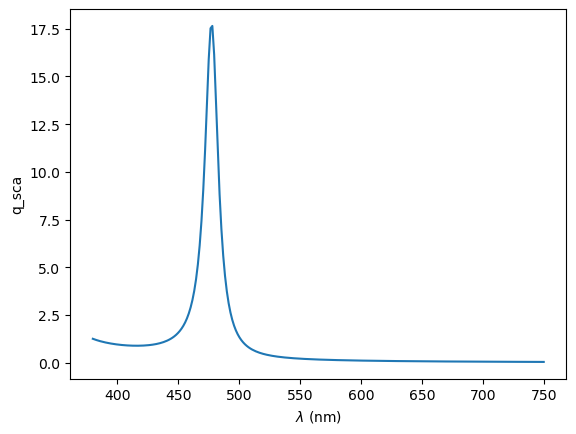

In [175]:
q_sca_start = pmd.farfield.cross_sections(
    k0=k0,
    r_c=core_radius,
    eps_c=core_refractiveIndex ** 2,
    r_s=shell_radius,
    eps_s=shell_refractiveIndex ** 2,
    eps_env=1.44,
    n_max=8,
)[optim_expression]

plt.plot(wl.detach(), q_sca_start.detach(), label = "Starting spetra.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.show()

In [176]:
r_c = torch.tensor(core_radius, requires_grad=True)
r_s = torch.tensor(shell_radius, requires_grad=True)
n_c = torch.tensor(core_refractiveIndex, requires_grad=False)
n_s = torch.tensor(shell_refractiveIndex, requires_grad=True)

In [177]:
def FOM(args, wl_target_indx):

    sca_iter = pmd.farfield.cross_sections(*args)["q_sca"]
    abs_iter = pmd.farfield.cross_sections(*args)["q_abs"]

    sca_mean = torch.mean(sca_iter)

    abs_max = torch.max(abs_iter)

    return torch.mean(sca_iter[wl_target_indx])/(2*sca_mean + abs_max)


In [178]:
wl

tensor([380.0000, 381.4859, 382.9719, 384.4578, 385.9438, 387.4297, 388.9157,
        390.4016, 391.8876, 393.3735, 394.8594, 396.3454, 397.8313, 399.3173,
        400.8032, 402.2892, 403.7751, 405.2610, 406.7470, 408.2329, 409.7189,
        411.2048, 412.6908, 414.1767, 415.6627, 417.1486, 418.6345, 420.1205,
        421.6064, 423.0924, 424.5783, 426.0643, 427.5502, 429.0361, 430.5221,
        432.0080, 433.4940, 434.9799, 436.4659, 437.9518, 439.4378, 440.9237,
        442.4096, 443.8956, 445.3815, 446.8675, 448.3534, 449.8394, 451.3253,
        452.8112, 454.2972, 455.7831, 457.2691, 458.7550, 460.2410, 461.7269,
        463.2129, 464.6988, 466.1847, 467.6707, 469.1566, 470.6426, 472.1285,
        473.6145, 475.1004, 476.5863, 478.0723, 479.5582, 481.0442, 482.5301,
        484.0161, 485.5020, 486.9880, 488.4739, 489.9598, 491.4458, 492.9317,
        494.4177, 495.9036, 497.3896, 498.8755, 500.3614, 501.8474, 503.3333,
        504.8193, 506.3052, 507.7912, 509.2771, 510.7631, 512.24

In [179]:
lower_bound = 457.5 #458.0
upper_bound = 459.5

wl_target_indx = torch.nonzero((wl >= lower_bound) & (wl <= upper_bound), as_tuple=True)

In [180]:
wl_target_indx

(tensor([53]),)

In [181]:
q_sca_start[wl_target_indx]

tensor([2.5765], dtype=torch.float64)

In [ ]:
import torch
import time

t0 = time.time()
optimizer = torch.optim.LBFGS([r_c, r_s, n_s], lr=0.05, max_iter=7, history_size=5) # LBFGS-specific params

max_iter = 25
losses = []  # Array to store loss data

def closure():
    optimizer.zero_grad()  # Reset gradients

    args = (k0, r_c, n_c**2, r_s, n_s**2, 1.44)

    penalty_loss = 0
    if (n_s.real < 0) or (n_s.imag < 0):
        # penalty_loss =  0.001 / n_s.real + 0.001 / n_s.imag
        penalty_loss = penalty_loss + 0.5
    else:
        penalty_loss = 0.0


    fom = FOM(args, wl_target_indx)
    print(f"fom {fom.item()}",(-0.1*fom+0.2).item())


    # iteration_n = pmd.farfield.cross_sections(*args)[optim_expression]
    loss = -0.1*fom+0.2+ penalty_loss

    loss.backward()  # Compute gradients
    return loss

for o in range(max_iter + 1):
    loss = optimizer.step(closure)  # LBFGS requires closure

    losses.append(loss.item())  # Store loss value

    if o % 5 == 0:
        print(o, loss.item())

t1 = time.time()
print(t1 - t0)

fom 0.6045768145350966 0.13954231854649035
fom 0.7793646480317798 0.12206353519682202
fom 0.7872345635006304 0.12127654364993697
fom 1.0275476724657178 0.09724523275342822
fom 0.4716208320871256 0.15283791679128744
fom 0.4722507728959009 0.15277492271040993
fom 0.47288625159388575 0.15271137484061142
0 0.13954231854649035
fom 0.47352738359827623 0.1526472616401724
fom 0.4741742864060528 0.15258257135939474
fom 0.4748270989248248 0.15251729010751752
fom 0.47548588515780343 0.15245141148421967
fom 0.47615083674301756 0.15238491632569826
fom 0.47682204138714007 0.152317795861286
fom 0.4774982335284175 0.15225017664715826
fom 0.47818237658731666 0.15218176234126835
fom 0.4788717811947523 0.15211282188052477
fom 0.47956660715276717 0.1520433392847233
fom 0.48026975962222984 0.15197302403777702
fom 0.4809800456874001 0.15190199543125998
fom 0.48169758045641803 0.1518302419543582
fom 0.48241974713983427 0.1517580252860166
fom 0.48314950083317415 0.15168504991668258
fom 0.4838884412788937 0.15

In [183]:
print("final:", [f"{d.detach().numpy():.3f}" for d in [r_c, r_s, n_c, n_s]])


args = (k0, r_c, n_c**2, r_s, n_s**2)

q_sca = pmd.farfield.cross_sections(*args)["q_sca"]
q_abs = pmd.farfield.cross_sections(*args)["q_abs"]

final: ['1.000', '39.982', '1.450+0.000j', '6.884-0.003j']


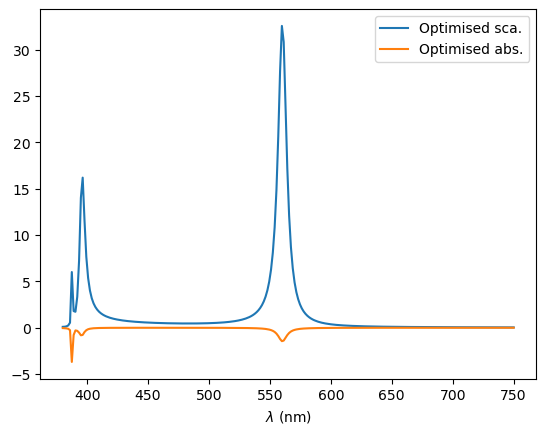

In [184]:
plt.plot(wl.detach(), q_sca.detach(), label = "Optimised sca.")
plt.plot(wl.detach(), q_abs.detach(), label = "Optimised abs.")
#plt.ylim([-2, 2])
plt.xlabel("$\lambda$ (nm)")
plt.legend()
plt.show()

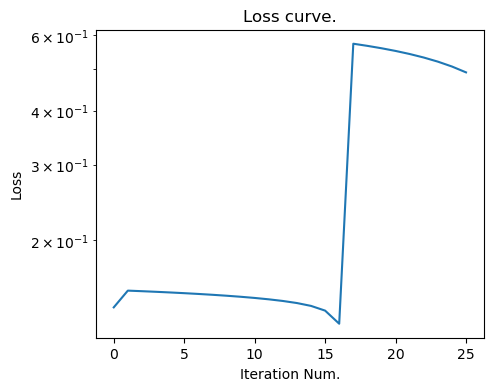

In [185]:
plt.figure(figsize=(5, 4))
plt.subplot(title="Loss curve.")
plt.plot(losses)
plt.xlabel("Iteration Num.")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
